In [1]:
# %tensorflow_version 1.x
import numpy as np   #Package for scientific computing and dealing with arrays
import pandas as pd  #Package providing fast, flexible and expressive data structures
import re            #re stands for RegularExpression providing full support for Perl-like Regular Expressions in Python
from bs4 import BeautifulSoup   #Package for pulling data out of HTML and XML files
# from keras.preprocessing.text import Tokenizer  # This import is incorrect in some versions of Keras
from tensorflow.keras.preprocessing.text import Tokenizer  #For tokenizing the input sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences  #For Padding the seqences to same length
from nltk.corpus import stopwords   #For removing filler words
from tensorflow.keras.layers import Input, LSTM, Attention, Embedding, Dense, Concatenate, TimeDistributed   #Layers required to implement the model
from tensorflow.keras.models import Model  #Helps in grouping the layers into an object with training and inference features
from tensorflow.keras.callbacks import EarlyStopping  #Allows training the model on large no. of training epochs & stop once the performance stops improving on validation dataset
import warnings  #shows warning message that may arise

pd.set_option("display.max_colwidth", 200) #Setting the data sructure display length
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

100%|██████████| 242M/242M [00:01<00:00, 148MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [3]:

import shutil
import os

source_directory = "/root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2"
destination_directory = "/content"

try:
    shutil.move(source_directory, destination_directory)
    print(f"Directory '{source_directory}' moved to '{destination_directory}' successfully.")
except FileNotFoundError:
    print(f"Source directory '{source_directory}' not found.")
except shutil.Error as e:
    print(f"An error occurred during the move operation: {e}")
except OSError as e:
    print(f"An OS error occurred: {e}")


#Verify if the directory exists in the destination
if os.path.exists(os.path.join(destination_directory, os.path.basename(source_directory))):
  print(f"Directory '{os.path.basename(source_directory)}' found in '{destination_directory}'")
else:
  print(f"Directory '{os.path.basename(source_directory)}' not found in '{destination_directory}'")

Directory '/root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2' moved to '/content' successfully.
Directory '2' found in '/content'


In [4]:
reviewsData=pd.read_csv("/content/2/Reviews.csv",nrows=30000) #Taking 30,000 out of 500,000 reviews
print(reviewsData.shape) #Analyzing the shape of the dataset
reviewsData.head(n=10)

(30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [5]:
DATASET_COLUMNS = ["Id", "ProductId", "UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Score", "Time", "Summary", "Text"]
reviewsData.columns = DATASET_COLUMNS
reviewsData.head(n=10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [6]:
reviewsData.drop(['Id', 'ProductId', 'UserId', 'ProfileName' , 'HelpfulnessNumerator' , 'HelpfulnessDenominator', 'Score' ,'Time'],axis = 1 ,inplace = True)
reviewsData.head(n=10)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,Nice Taffy,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,Great! Just as good as the expensive brands!,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,Yay Barley,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,Healthy Dog Food,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [7]:
#Reducing the length of dataset for better training and performance
reviewsData.drop_duplicates(subset=['Text'],inplace=True) #Dropping the rows with Duplicates values of 'Text'
reviewsData.dropna(axis=0,inplace=True) #Dropping the rows with Missing values

In [8]:
reviewsData.info() #Getting more info on datatypes and shape of Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 28677 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  28677 non-null  object
 1   Text     28677 non-null  object
dtypes: object(2)
memory usage: 672.1+ KB


In [9]:
#Preprocessing

#This the dictionary used for expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
#Text Cleaning
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def text_cleaner(text,num):
    newString = text.lower()  #converts all uppercase characters in the string into lowercase characters and returns it
    newString = BeautifulSoup(newString, "lxml").text #parses the string into an lxml.html
    newString = re.sub(r'\([^)]*\)', '', newString) #used to replace a string that matches a regular expression instead of perfect match
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) #for expanding contractions using the contraction_mapping dictionary
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    if(num==0):
      tokens = [w for w in newString.split() if not w in stop_words]  #converting the strings into tokens
    else :
      tokens = newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short words
            long_words.append(i)
    return (" ".join(long_words)).strip()

#Calling the function
cleaned_text = []
for t in reviewsData['Text']:
    cleaned_text.append(text_cleaner(t,0))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
reviewsData['Text'][:10] #Looking at the 'Text' column of the dataset

,Text
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
5,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there wa..."
6,"This saltwater taffy had great flavors and was very soft and chewy. Each candy was individually wrapped well. None of the candies were stuck together, which did happen in the expensive version, ..."
7,This taffy is so good. It is very soft and chewy. The flavors are amazing. I would definitely recommend you buying it. Very satisfying!!
8,Right now I'm mostly just sprouting this so my cats can eat the grass. They love it. I rotate it around with Wheatgrass and Rye too
9,This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.


In [12]:
cleaned_text[:10] #Looking at the Text after removing stop words, special characters , punctuations etc.

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband l

In [13]:
#Summary Cleaning
cleaned_summary = []    #Using the text_cleaner function for cleaning summary too
for t in reviewsData['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [14]:
reviewsData['Summary'][:10]

,Summary
0,Good Quality Dog Food
1,Not as Advertised
2,"""Delight"" says it all"
3,Cough Medicine
4,Great taffy
5,Nice Taffy
6,Great! Just as good as the expensive brands!
7,"Wonderful, tasty taffy"
8,Yay Barley
9,Healthy Dog Food


In [15]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [16]:
reviewsData['Cleaned_Text'] = cleaned_text  #Adding cleaned text to the dataset
reviewsData['Cleaned_Summary'] = cleaned_summary  #Adding cleaned summary to the dataset
#Dropping Empty Rows
reviewsData['Cleaned_Summary'].replace('', np.nan, inplace=True)
#Dropping rows with Missing values
reviewsData.dropna(axis=0,inplace=True)

In [17]:
#Before Cleaning
print("Before Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Text'][i])
    print("Summary:",reviewsData['Summary'][i])
    print("\n")

Before Preprocessing:

Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Summary: Good Quality Dog Food


Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Summary: Not as Advertised


Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat t

In [18]:
#Printing the Cleaned text and summary which will work as input to the model
print("After Preprocessing:\n")
for i in range(5):
    print("Review:",reviewsData['Cleaned_Text'][i])
    print("Summary:",reviewsData['Cleaned_Summary'][i])
    print("\n")

After Preprocessing:

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: delight says it all


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: cough medicine


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary: great taffy




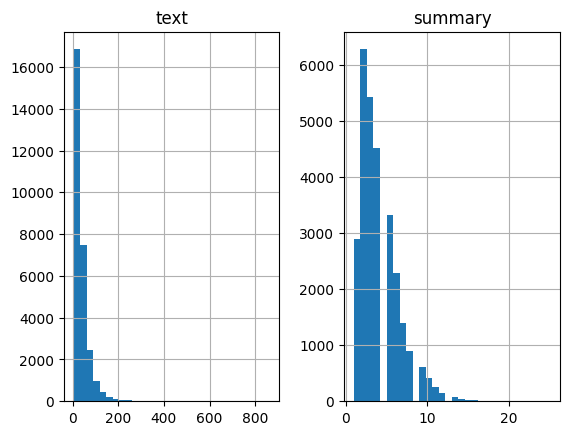

In [19]:
#Data Visualization
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

#Populating the lists with sentence lengths
for i in reviewsData['Cleaned_Text']:
      text_word_count.append(len(i.split()))

for i in reviewsData['Cleaned_Summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [20]:
#Function for getting the Maximum Review length
count=0
for i in reviewsData['Cleaned_Text']:
    if(len(i.split())<=35):
        count=count+1
print(count/len(reviewsData['Cleaned_Text']))

0.630776211084741


In [21]:
#Function for getting the Maximum Summary length
count=0
for i in reviewsData['Cleaned_Summary']:
    if(len(i.split())<=8):
        count=count+1
print(count/len(reviewsData['Cleaned_Summary']))

0.9437386569872959


In [22]:
#From the above data we got an idea about maximum lengths of review and summary
max_text_len = 35
max_summary_len = 8

In [23]:
#Adding START and END tags to summary for better decoding
cleaned_text =np.array(reviewsData['Cleaned_Text'])
cleaned_summary=np.array(reviewsData['Cleaned_Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [24]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [25]:
#Splitting the Dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.3,random_state=0,shuffle=True)

In [26]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.0 MB/s eta 0:00:00


In [27]:
#Preparing Tokenizer

#Text Tokenizer
#The original import was attempting to import from keras.preprocessing,
# but the correct location for Tokenizer is keras_preprocessing.text.
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

#preparing a tokenizer for reviews on training data
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

In [28]:
# #Preparing Tokenizer

# #Text Tokenizer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# #preparing a tokenizer for reviews on training data
# X_tokenizer = Tokenizer()
# X_tokenizer.fit_on_texts(list(X_train))

In [29]:
#Rarewords and their coverage in review
thresh = 4  #If a word whose count is less than threshold i.e 4, then it's considered as rare word

cnt = 0      #denotes no. of rare words whose count falls below threshold
tot_cnt = 0  #denotes size of unique words in the text
freq = 0
tot_freq = 0

for key,value in X_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 65.836553599542
Total Coverage of rare words: 5.320401458952551


In [30]:
#Defining the Tokenizer with top most common words for reviews

#Preparing a Tokenizer for reviews on training data
X_tokenizer = Tokenizer(num_words=tot_cnt-cnt)   #provides top most common words
X_tokenizer.fit_on_texts(list(X_train))

#Converting text sequences into integer sequences
X_train_seq    =   X_tokenizer.texts_to_sequences(X_train)
X_test_seq   =   X_tokenizer.texts_to_sequences(X_test)

#Padding zero upto maximum length
X_train    =   pad_sequences(X_train_seq,  maxlen = max_text_len, padding = 'post')
X_test   =   pad_sequences(X_test_seq, maxlen = max_text_len, padding = 'post')

#Size of vocabulary (+1 for padding token)
X_voc   =  X_tokenizer.num_words + 1

In [31]:
X_voc

4775

In [32]:
#Summary Tokenizer

#Preparing a Tokenizer for summaries on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [33]:
#Rarewords and their coverage in summary

thresh = 6  ##If a word whose count is less than threshold i.e 6, then it's considered as rare word

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt+1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt+1
        freq = freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 81.46718146718148
Total Coverage of rare words: 9.743558073829337


In [34]:
#Defining Tokenizer with the most common words in summary

#Preparing a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)  #provides top most common words
y_tokenizer.fit_on_texts(list(y_train))

#Converting text sequences into integer sequences
y_train_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_test_seq   =   y_tokenizer.texts_to_sequences(y_test)

#Padding zero upto maximum length
y_train    =   pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [35]:
y_voc

865

In [36]:
#Checking the length of training data
y_tokenizer.word_counts['sostok'],len(y_train)

(12278, 12278)

In [37]:
#Deleting rows containing START and END tokens
#For Training set
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train=np.delete(y_train,ind, axis=0)
X_train=np.delete(X_train,ind, axis=0)

In [38]:
#For Validation set
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test=np.delete(y_test,ind, axis=0)
X_test=np.delete(X_test,ind, axis=0)

In [39]:
#Model Building

#Adding Custom Attention layer

import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [40]:
import tensorflow.keras.backend as K

# Use K.zeros_like() instead of keras.api.backend.zeros_like()
K.clear_session()  #Resets all state generated by Keras

latent_dim = 256
embedding_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(X_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#Setting up the Decoder using 'encoder_states' as initial state
decoder_inputs = Input(shape=(None,))

#Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

#Defining the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      1,222,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 35, 256),      │        525,312 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 35, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │        221,440 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 35, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        525,312 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 256),    │        131,328 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 35)]      │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 865)      │        443,745 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,120,161 (15.72 MB)

 Trainable params: 4,120,161 (15.72 MB)

 Non-trainable params: 0 (0.00 B)

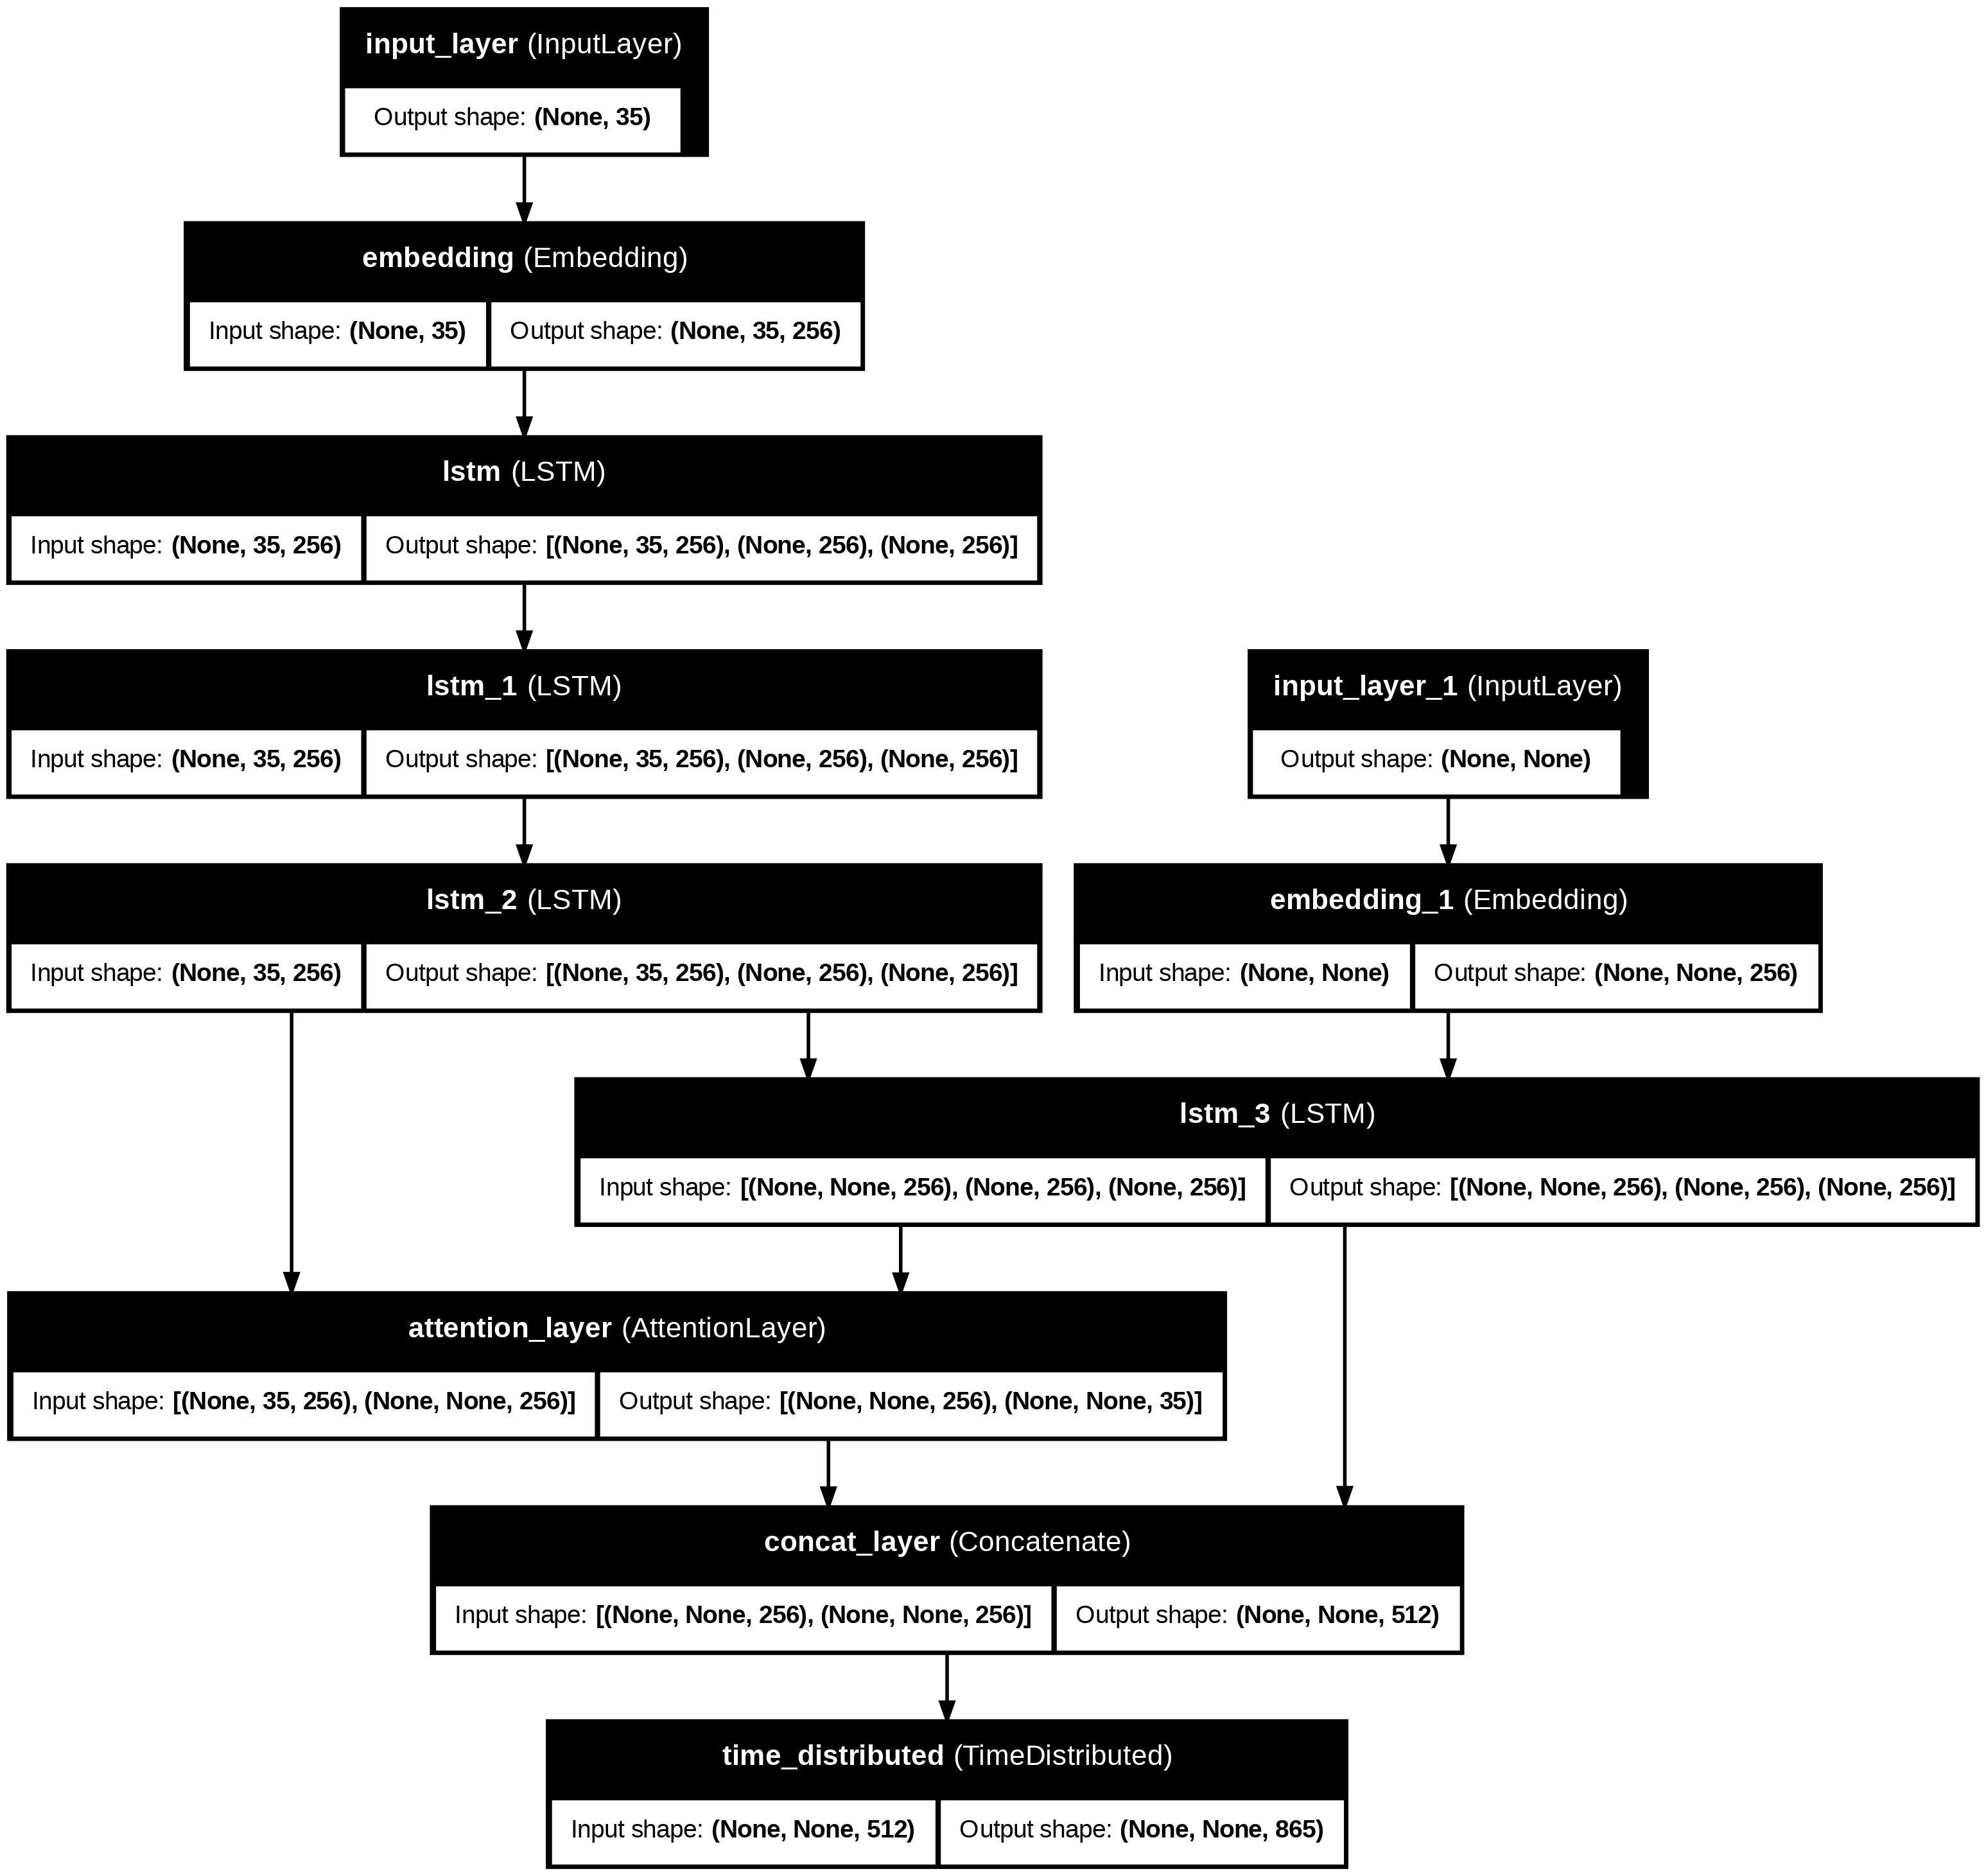

In [41]:
#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
#Adding Metrics
model.compile(optimizer='rmsprop' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])

In [43]:
# Training the Model without Early Stopping
history = model.fit(
    [X_train, y_train[:, :-1]],
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
    epochs=100,
    batch_size=64,
    validation_data=([X_test, y_test[:, :-1]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:, 1:])
)


Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 64s 229ms/step - accuracy: 0.5261 - loss: 3.2185 - val_accuracy: 0.6164 - val_loss: 2.4433
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 42s 231ms/step - accuracy: 0.6081 - loss: 2.4876 - val_accuracy: 0.6164 - val_loss: 2.4031
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 81s 226ms/step - accuracy: 0.6149 - loss: 2.3999 - val_accuracy: 0.6180 - val_loss: 2.3359
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - accuracy: 0.6095 - loss: 2.3677 - val_accuracy: 0.6209 - val_loss: 2.2831
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.6157 - loss: 2.2845 - val_accuracy: 0.6225 - val_loss: 2.2478
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 82s 224ms/step - accuracy: 0.6170 - loss: 2.2467 - val_accuracy: 0.6256 - val_loss: 2.2092
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.6208 - loss: 2.1964 - val_accuracy: 0.6284 - val_loss: 2.1763
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.6261 -

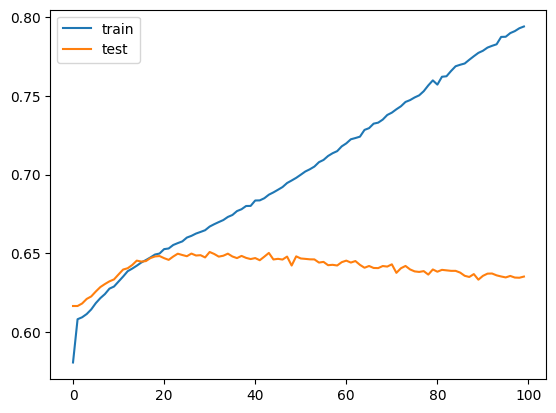

In [44]:
#Visualizing Accuracy
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train') # Changed 'acc' to 'accuracy'
pyplot.plot(history.history['val_accuracy'], label='test') # Changed 'val_acc' to 'val_accuracy'
pyplot.legend()
pyplot.show()

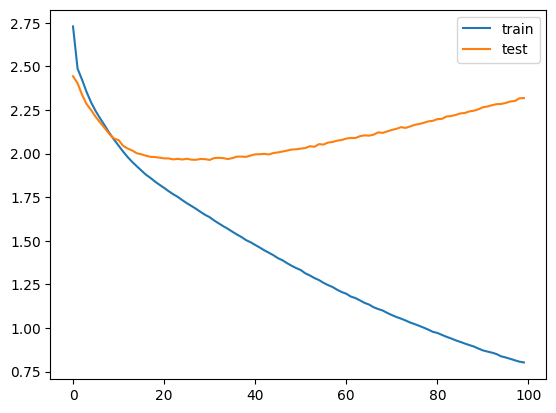

In [45]:
#Visualizing Loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [46]:
#Building Dictionary for Source Vocabulary
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=X_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [47]:
#Inference/Validation Phase
#Encoding the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder setup
#These tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

#Getting the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

#Setting the initial states to the states from the previous time step for better prediction
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

#Final Decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
#Function defining the implementation of inference process
def decode_sequence(input_seq):
    #Encoding the input as state vectors
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    #Generating empty target sequence of length 1
    target_seq = np.zeros((1,1))

    #Populating the first word of target sequence with the start word
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        #Sampling a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        #Exit condition: either hit max length or find stop word
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        #Updating the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        #Updating internal states
        e_h, e_c = h, c

    return decoded_sentence

In [49]:
#Functions to convert an integer sequence to a word sequence for summary as well as reviews
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [50]:
!pip install rouge-score  # Install the rouge-score package

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=144d1e2764cf67f2809425fb221f27fa0b0c8fb3339075e1411db7264923cb1c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [51]:
from rouge_score import rouge_scorer  # Importing the rouge_scorer module

# Initialize the scorer for ROUGE-1, ROUGE-2, and ROUGE-L
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge_scores(original_summary, predicted_summary):
    scores = scorer.score(original_summary, predicted_summary)
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure
    }

# Lists to store individual scores
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for i in range(0, 20):
    original_summary = seq2summary(y_train[i])
    predicted_summary = decode_sequence(X_train[i].reshape(1, max_text_len))

    # Calculate ROUGE scores
    scores = calculate_rouge_scores(original_summary, predicted_summary)
    rouge1_scores.append(scores['rouge1'])
    rouge2_scores.append(scores['rouge2'])
    rougeL_scores.append(scores['rougeL'])

    # Print the results
    print("Review:", seq2text(X_train[i]))
    print("Original summary:", original_summary)
    print("Predicted summary:", predicted_summary)
    print("Rouge1 Score:", scores['rouge1'])
    print("Rouge2 Score:", scores['rouge2'])
    print("RougeL Score:", scores['rougeL'])
    print("\n")

# Calculate averages
average_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
average_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
average_rougeL = sum(rougeL_scores) / len(rougeL_scores)

# Print average scores
print("Average Rouge1 Score:", average_rouge1)
print("Average Rouge2 Score:", average_rouge2)
print("Average RougeL Score:", average_rougeL)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Review: big box favorite candy good price candy would expect store bought package individually wrapped plastic wrappers 
Original summary: yum 
Predicted summary:  yum
Rouge1 Score: 1.0
Rouge2 Score: 0.0
RougeL Score: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Review: like coffee much better instant keep packs desk long also started carrying go camping go another cup instant coffee jar happy 
Original summary: good coffee 
Predicted summary:  coffee
Rouge1 Score: 0.6666666666666666
Rouge2 Score: 0.0
RougeL Score: 0.6666666666666666


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Review: ziwipeak excellent product ten pound chihuahua suffers skin allergies t